# Minecraft Crop Layout Efficiency Simulator
## By: Tim Lupien

## Background Information

This notebook is designed to find the frequency at which to harvest Minecraft crops of an arbitrary kind in an arbitrary layout to maximize the crop yield per hour. Before getting into the code, I will briefly outline some of the underlying concepts.

### Random Ticks
Most crops in minecraft are governed by a game mechanic called the **random tick**. In Java edition (the focus of my analysis), 3 random ticks ocurr at random positions within a chunk section every 1/20 of a second. A **chunk section** is a 16 by 16 by 16 group of blocks. Note that air (empty) blocks *are* counted for this purpose.

### Growth Stages
For crops that stay the same size (wheat, beetroot, carrots, potatoes, abbreviated WBCP), the crop has a certain number of **growth stages**. Each time the crop is hit with a random tick, there is *the possibility* that its growth stage will increase by 1. Once the crop reaches its maximum growth stage, it is ready to be harvested.

For crops that actually increase their size in terms of blocks tall (sugarcane, cactus, bamboo, and kelp), the concept of growth stages still generally applies, but with the additional caveat that height determines the benefit of harvesting such a crop. So while a sugarcane can become 3 crops tall, you could still harvest it when it was 2 crops tall and just get (1) fewer sugarcane.

In light of this, I use the convention that each *harvest-relevant* quantity of growth will be worth one (1). Thus each time wheat, which has 8 growth stages, is hit with a *successful* random tick, the figure representing its growth will increase by 1/8, to a maximum of 1, while sugarcane, which takes 16 growth stages to increase in height by 1, will grow by 1/16, to a maximum of 3.

### Growth Probability
I mentioned earlier that on each random tick there is *the possibility* of a growth stage increase. For some crops, this is represented by a pre-determined probability, but for others (WBCP) it is what I call **lookup-based**. Lookup-based growth calculates a number of "points" to pass to a formula which determines the growth probability based on these rules:
- \+ 2 / \+ 4 points for being planted on dry / hydrated farmland
- \+ 0.25 / \+ 0.75 points for each adjacent crop that is dry / hydrated farmland
- points are halved ( / 2) if:
    - any diagonally adjacent bock has the same crop planted on it
    - any combination of vertically or horizontally adjacent crops have the same crop planted in them
    
Points are an input (p) to this formula:
$$ \left(\frac{1}{\lfloor\frac{25}{p} \rfloor + 1}\right)$$
Which gives the growth probability for that crop under the specific circumstances.

### Farm Layouts
I create a layout as an array of integers representing each crop / hydration combination, which are associated to the relevant factors for simulation (hydration status, starting growth stage, growth stage size, growth probability, and maximum growth).

Furthermore, due to the lookup-based growth's reliance on adjacent blocks, crops on the edges of the layout need some information about blocks outside of the layout. To deal with this, there will be a uniform assumption that the border of the farm is non-farmland blocks.

All of this information is from https://minecraft.fandom.com/wiki/Tutorials/Crop_farming and other pages on the same website.

## Implementation:

In [1]:
#setup chunk
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
np.set_printoptions(linewidth = 4096)

import itertools as it

In [2]:
# Format:
# ID : [Hydration Status,
# Starting Growth Stage,
# Growth Stage Size,
# Growth Probability,
# Maximum Growth]

crop_dict = {
    1  : [False, 0, 1/8, 'L',    1],   # wheat
    2  : [False, 0, 1/4, 'L',    1],   # beetroot
    3  : [False, 0, 1/8, 'L',    1],   # carrot
    4  : [False, 0, 1/8, 'L',    1],   # potato
    5  : [False, 1, 1/16, 1,     3],   # sugarcane
    6  : [False, 1, 1/16, 1,     3],   # cactus
    7  : [False, 1, 1/3,  1,    'B'],  # bamboo
    8  : [False, 1, 1,    0.14, 'K'],  # kelp
    11 : [True,  0, 1/8, 'L',    1],   # same order as above,
    12 : [True,  0, 1/4, 'L',    1],   # but hydrated versions
    13 : [True,  0, 1/8, 'L',    1],
    14 : [True,  0, 1/8, 'L',    1],
    15 : [True,  1, 1/16, 1,     3],
    16 : [True,  1, 1/16, 1,     3],
    17 : [True,  1, 1/3,  1,    'B'],
    18 : [True,  1, 1,    0.14, 'K'],
    0  : [np.NaN, np.NaN, np.NaN, np.NaN, np.NaN]  # placeholder
}

In [3]:
def get_start_state(layout, crop_dict = crop_dict):
    '''This looks up the starting growth for each crop in the layout,
    creating an array where the index of a crop can be used to
    reference its growth rate.'''
    
    start_state = []
    for row in layout:
        for crop in row:
                start_state.append(crop_dict[crop][1])
    start_state = np.array(start_state).reshape(layout.shape)
    return start_state
    

In [4]:
def get_growth_prob(layout, crop_dict = crop_dict):
    '''This creates an array of probabilities where the index of the
    crop can be used to reference its probability of growing upon
    being hit with a random tick.'''
    
    growth_prob = []
    for i in range(layout.shape[0]):
        for j in range(layout.shape[1]):
            
            crop = layout[i,j]
            
            # lookup-based probabilities
            if crop_dict[crop][3] == 'L':

                # finding the adjacent crops

                adj_finder = list(it.product([-1,0,1], repeat = 2))
                adj_finder = adj_finder[:4] + adj_finder[5:] # remove middle
                
                adj = []
                for k in adj_finder:
                    coords = tuple(np.array([i,j]) + np.array(k))
                    
                    # for edges, count the adjacent block as 0
                    if 0 <= coords[0] < layout.shape[0]\
                    and 0 <= coords[1] < layout.shape[1]:
                        adj.append(layout[coords])
                        
                    else:
                        adj.append(0)

                neighbors = adj
                diagonals = [adj[0],adj[2],adj[5],adj[7]]

                # calculating points for probability formula
                p = 0

                # hydration
                if crop_dict[crop][0]:
                    p += 4
                else:
                    p += 2

                # adjacent hydration
                for adj_crop in neighbors:
                    if adj_crop == 0:
                        pass
                    elif crop_dict[adj_crop][0]:
                        p += 0.75
                    else:
                        p += 0.25

                # layout conditions        
                bad_planting = False

                # diagonals
                if any([diag_crop == crop for diag_crop in diagonals]):
                    bad_planting = True

                # horizontal and vertical mix    
                if adj[1] == crop and adj[4] == crop:
                    bad_planting = True

                if adj[1] == crop and adj[3] == crop:
                    bad_planting = True

                if adj[6] == crop and adj[4] == crop:
                    bad_planting = True

                if adj[6] == crop and adj[3] == crop:
                    bad_planting = True

                # halving p (if applicable)
                if bad_planting:
                    p = p / 2

                # final growth rate
                growth_rate = (1/(25 // p + 1))
                growth_prob.append(growth_rate)

                # non-lookup probabilities
            else:
                 growth_prob.append(crop_dict[crop][3])
                                       
    growth_prob = np.array(growth_prob).reshape(layout.shape)
    return growth_prob                                       

In [5]:
def get_stage_size(layout, crop_dict = crop_dict):
    '''Creates reference array for the what number to add when a growth
    stage is added (index matches layout index of crop)'''
    
    stage_size = []
    for row in layout:
        for crop in row:
                stage_size.append(crop_dict[crop][2])
    stage_size = np.array(stage_size).reshape(layout.shape)
    return stage_size

In [6]:
def get_max_growth(layout, crop_dict = crop_dict):
    '''Creates reference array containing each crop's max growth.'''
    
    max_growth = []
    for row in layout:
        for crop in row:
            if crop_dict[crop][4] == 'B':
                max_growth.append(np.random.randint(12,17))
            elif crop_dict[crop][4] == 'K':
                max_growth.append(26 - np.random.randint(25))
            else:
                max_growth.append(crop_dict[crop][4])
    max_growth = np.array(max_growth).reshape(layout.shape)
    return max_growth

In [7]:
def to_section(layout):
    '''Create a 3d array where the layout occupies the rows and columns
    at the lowest index (technically the top left of the bottom "pane")
    for use in simulating all of the randomticks that would land on
    air. As the section will be put through randomticks recursively, it
    uses the start state reference array, rather than the actual
    layout.'''
    
    start_state = get_start_state(layout)
    # if smaller than 16 by 16:
    n_new_row = 16 - start_state.shape[0]
    n_new_col = 16 - start_state.shape[1]
    
    new_row = np.full(start_state.shape[1], np.NaN)
    for _ in range(n_new_row):
        start_state = np.vstack([start_state, new_row])
    
    new_col = np.full(start_state.shape[0], np.NaN)[:,np.newaxis]
    for _ in range(n_new_col):
        start_state = np.hstack([start_state, new_col])
        
    rest_of_section = np.full([16,16,15], np.NaN)
    section = np.dstack([start_state, rest_of_section])
                      
    return section

In [8]:
def randomtick(section, growth_prob, stage_size, max_growth, tick_rate = 3):
    '''Each call of this function will simulate one game-tick's worth
    (the tick rate) of randomticks on a section. If randomticks land on
    non-empty places, there is a chance determined by the growth_prob
    reference array that the number contained in the space will be
    incremented by the number in the stage_size reference array. Each
    space is capped by its corresponding max growth in that array.'''
    
    previous_ticks = []
    for i in range(tick_rate):
        
        # pick a block to tick
        while True:
            tick_index = tuple(np.random.choice(np.arange(16), 3, replace=True))
            if tick_index not in previous_ticks:
                break
        previous_ticks.append(tick_index)
        ticked_block = section[tick_index]
        
        # ignore if empty
        if np.isnan(ticked_block):
            continue
        
        else:
            flat_index = (tick_index[0], tick_index[1]) # just 2d,
            # ^for reference arrays
            
            # growth applied
            growth_success = np.random.binomial(1, growth_prob[flat_index])
            
            if growth_success == 1:
                ticked_block += stage_size[flat_index]
            
            # max growth cap
            if ticked_block > max_growth[flat_index]:
                ticked_block = max_growth[flat_index]
                
            section[tick_index] = ticked_block # update complete
            
    return section

In [9]:
def single_sim(layout):
    '''This function runs a single simulation given the layout,
    applying randomticks to the section until all crops are fully
    grown. It returns an array of growth beyond the initial state at
    each iteration.'''
    
    # setup
    section = to_section(layout)
    starting_growth = np.nansum(section // 1)
    growth_prob = get_growth_prob(layout)
    stage_size = get_stage_size(layout)
    max_growth = get_max_growth(layout)
    
    # run the section through simulation
    growth_tracking = []
    while np.nansum(section) != np.nansum(max_growth):
        section = randomtick(section, growth_prob, stage_size, max_growth)
        growth_tracking.append((np.nansum(section // 1) - starting_growth))
        
    growth_tracking = np.array(growth_tracking)
    return growth_tracking

## Sugarcane Test

With the simulation ready to go, let's test it. Sugarcane (represented by 5) must be next to water in order to grow. Since water can't have a crop planted on it, the water ends up equivalent to an empty block for our purposes, and can be represented with 0. Here is relatively good sugarcane layout, simulated.

In [10]:
# a one-chunk sugarcane farm with water
test_layout = np.array([
    [0, 5, 5, 5, 0, 5, 5, 5, 0, 5, 5, 5, 0, 5, 5, 5],
    [5, 5, 0, 5, 5, 5, 0, 5, 5, 5, 0, 5, 5, 5, 0, 5],
    [0, 5, 5, 5, 0, 5, 5, 5, 0, 5, 5, 5, 0, 5, 5, 5],
    [5, 5, 0, 5, 5, 5, 0, 5, 5, 5, 0, 5, 5, 5, 0, 5],
    [0, 5, 5, 5, 0, 5, 5, 5, 0, 5, 5, 5, 0, 5, 5, 5],
    [5, 5, 0, 5, 5, 5, 0, 5, 5, 5, 0, 5, 5, 5, 0, 5],
    [0, 5, 5, 5, 0, 5, 5, 5, 0, 5, 5, 5, 0, 5, 5, 5],
    [5, 5, 0, 5, 5, 5, 0, 5, 5, 5, 0, 5, 5, 5, 0, 5],
    [0, 5, 5, 5, 0, 5, 5, 5, 0, 5, 5, 5, 0, 5, 5, 5],
    [5, 5, 0, 5, 5, 5, 0, 5, 5, 5, 0, 5, 5, 5, 0, 5],
    [0, 5, 5, 5, 0, 5, 5, 5, 0, 5, 5, 5, 0, 5, 5, 5],
    [5, 5, 0, 5, 5, 5, 0, 5, 5, 5, 0, 5, 5, 5, 0, 5],
    [0, 5, 5, 5, 0, 5, 5, 5, 0, 5, 5, 5, 0, 5, 5, 5],
    [5, 5, 0, 5, 5, 5, 0, 5, 5, 5, 0, 5, 5, 5, 0, 5],
    [0, 5, 5, 5, 0, 5, 5, 5, 0, 5, 5, 5, 0, 5, 5, 5],
    [5, 5, 0, 5, 5, 5, 0, 5, 5, 5, 0, 5, 5, 5, 0, 5]
    ])

In [11]:
growth = single_sim(test_layout)

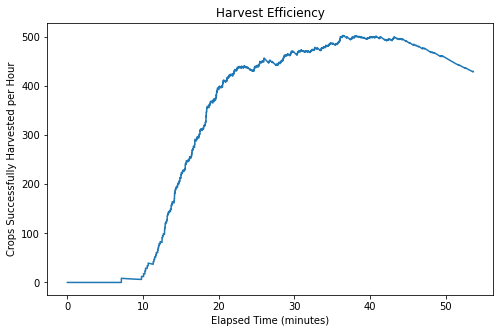

In [21]:
# using the information
time = np.arange(1, growth.size + 1) # number of ticks, for x-axis


# optional replanting time requirement essentially time between the end
# of a growth cycle and the start of another (in ticks (1/20 second))
replanting = 0 

# efficiency in terms of "plants successfully harvested" so if a plant
# has not reached the next full growth stage, it doesn't count, hence
# the integer division. 20 * 60 * 60 is an hour to gameticks
# conversion.
efficiency = ((20*60*60) / (time + replanting)) * growth

# visualization
fig = plt.figure(figsize=(8, 5))
plt.plot(time, efficiency)
plt.xlabel('Elapsed Time (minutes)')
plt.xticks(np.array(list(set(time // 12000))) * 12000,
           labels=np.array(list(set(time // 12000)))*10)
plt.ylabel('Crops Successfully Harvested per Hour')
plt.title('Harvest Efficiency');

### Sugarcane conclusion
As you can see from the single curve, its best to harvest sugarcane around the 35 minute mark, when most of the plants are at either two or three growth stages. Some time after this point, the efficiency starts to go down. This is because there are too many plants sitting at full growth while the last few fill in for it to be worth it to wait, a common problem.

## Crop Rows example
Now let's use this tool to compare two layouts. Let's say I want to grow carrots. I could just plant a nice 9 by 9 square of them (with water in the middle), but since one of the rules determining this crop's growth probability is its adjacency to other carrots, I might actually have better luck planting alternating rows of potatoes and carrots. Let's make both layouts and put them on the same graph.

In [13]:
# just carrots
mono_layout = np.array([
    [13,13,13,13,13,13,13,13,13],
    [13,13,13,13,13,13,13,13,13],
    [13,13,13,13,13,13,13,13,13],
    [13,13,13,13,13,13,13,13,13],
    [13,13,13,13, 0,13,13,13,13],
    [13,13,13,13,13,13,13,13,13],
    [13,13,13,13,13,13,13,13,13],
    [13,13,13,13,13,13,13,13,13],
    [13,13,13,13,13,13,13,13,13]
])

In [14]:
mono_growth = single_sim(mono_layout)

In [15]:
# carrots and potatoes
alter_layout = np.array([
    [13,13,13,13,13,13,13,13,13],
    [14,14,14,14,14,14,14,14,14],
    [13,13,13,13,13,13,13,13,13],
    [14,14,14,14,14,14,14,14,14],
    [13,13,13,13, 0,13,13,13,13],
    [14,14,14,14,14,14,14,14,14],
    [13,13,13,13,13,13,13,13,13],
    [14,14,14,14,14,14,14,14,14],
    [13,13,13,13,13,13,13,13,13]
])

In [16]:
alter_growth = single_sim(alter_layout)

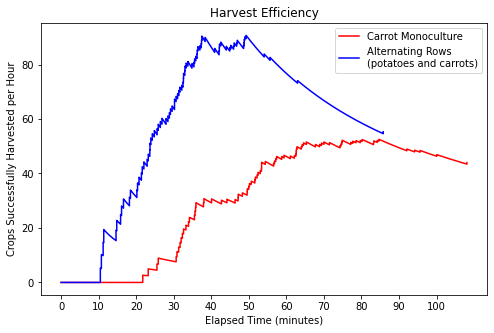

In [22]:
replanting = 1200 # for carrots let's say it takes a minute to replant

mono_time = np.arange(1, mono_growth.size + 1)
mono_efficiency = (20*60*60 / (mono_time + replanting)) * mono_growth

alter_time = np.arange(1, alter_growth.size + 1)
alter_efficiency = (20*60*60 / (alter_time + replanting)) * alter_growth

fig = plt.figure(figsize=(8, 5))
plt.plot(mono_time, mono_efficiency, c='red', label='Carrot Monoculture')
plt.plot(alter_time, alter_efficiency, c='blue',
         label='Alternating Rows\n(potatoes and carrots)')
plt.xlabel('Elapsed Time (minutes)')
plt.xticks(np.array(list(set(mono_time // 12000))) * 12000,
           labels=np.array(list(set(mono_time // 12000)))*10)
plt.ylabel('Crops Successfully Harvested per Hour')
plt.title('Harvest Efficiency')
plt.legend();

### Crop Rows Conclusion
As you can see, the harvest efficiency of the alternating rows is much greater. When you account for the fact that half of that "crops successfully harvested per hour" number is potatoes, you're still getting the same number of carrots per hour as with the carrot monoculture farm. You're just also getting the same quantity of potatoes! Seems like a much better deal.

## Overall Conclusion
This was a fun challenge I gave myself when I was first studying numpy arrays in-depth back in November/December 2021 (though I've cleaned it up a little since then). Hopefully it serves to illustrate not only my proficiency in that area, but my overall analytical approach and how I can use data science to achieve business objectives. Thank you for your time in taking a look at this.